In [4]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler  
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import losses 
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization,Dropout,AveragePooling2D
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

#  Fonction pour charger les images et les étiquettes
def load_dataset(directory, label_encoder=None, img_size=(128, 128)):
    images = []
    labels = []

    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            img_path = os.path.join(class_path, file)
            try:
                img = load_img(img_path, target_size=img_size)
                img = img_to_array(img)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Erreur lors du chargement de {img_path} : {e}")

    images = np.array(images, dtype="float32") / 255.0
    labels = np.array(labels)

    if label_encoder is None:
        label_encoder = LabelEncoder()
        labels = label_encoder.fit_transform(labels)
    else:
        labels = label_encoder.transform(labels)

    return images, labels, label_encoder

# 📁 Chemins vers les dossiers
train_dir = "C:/Users/HP/Desktop/PNEUM_O/chest_xray/train"
test_dir = "C:/Users/HP/Desktop/PNEUM_O/chest_xray/test"
img_size = (128, 128)

#  Chargement des datasets
x_train, y_train, le = load_dataset(train_dir, img_size=img_size)
x_test, y_test, _ = load_dataset(test_dir, label_encoder=le, img_size=img_size)

#  Affichage des formes
print("Train :", x_train.shape, y_train.shape)
print("Test  :", x_test.shape, y_test.shape)


Train : (5216, 128, 128, 3) (5216,)
Test  : (624, 128, 128, 3) (624,)


In [6]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Taille des images
img_size = (128, 128)

# ================================
# Chargement des données TRAIN
# ================================
train_dir = "C:/Users/HP/Desktop/PNEUM_O/chest_xray/train"

x_train = []
y_train = []

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            file_path = os.path.join(label_path, file)
            try:
                img = load_img(file_path, target_size=img_size)
                img_array = img_to_array(img) / 255.0
                x_train.append(img_array)
                y_train.append(label)
            except Exception as e:
                print(f"Erreur avec {file_path} : {e}")

x_train = np.array(x_train, dtype="float32")
y_train = np.array(y_train)

# ================================
# Chargement des données TEST
# ================================
test_dir = "C:/Users/HP/Desktop/PNEUM_O/chest_xray/test"

x_test = []
y_test = []

for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            file_path = os.path.join(label_path, file)
            try:
                img = load_img(file_path, target_size=img_size)
                img_array = img_to_array(img) / 255.0
                x_test.append(img_array)
                y_test.append(label)
            except Exception as e:
                print(f"Erreur avec {file_path} : {e}")

x_test = np.array(x_test, dtype="float32")
y_test = np.array(y_test)

# ================================
# Encodage des labels
# ================================
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)



In [7]:
x_train.shape

(5216, 128, 128, 3)

In [8]:
x_test.shape

(624, 128, 128, 3)

In [9]:
y_train_encoded.shape

(5216,)

In [10]:
train_images, test_images,train_labels, test_labels=train_test_split(x_train,y_train_encoded,test_size=0.2,random_state=42)

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear una instancia de ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.5,
    height_shift_range=0.2,
    zoom_range=0.2,
    #horizontal_flip=True,
)

 

def augment_images(X_train, y_train, num_augments=4):
    X_augmented = []
    y_augmented = []

    for i in range(len(X_train)):
        # Reshape 
        img = X_train[i].reshape((1,) + X_train[i].shape)
        
        # Generer les versiones augmenté
        augment_iter = datagen.flow(img, batch_size=1)
        for _ in range(num_augments):
            aug_img = next(augment_iter)[0]  
            X_augmented.append(aug_img)
            y_augmented.append(y_train[i])
    
    # 
    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    
    return X_augmented, y_augmented
# 
X_augmented, y_augmented = augment_images(train_images, train_labels, num_augments=4)

In [12]:
X_augmented.shape

(16688, 128, 128, 3)

In [13]:
# Combiner les images originales y augmentés
train_images = np.concatenate((train_images, X_augmented), axis=0)
train_labels = np.concatenate((train_labels, y_augmented), axis=0)

In [14]:
train_images.shape

(20860, 128, 128, 3)

In [15]:
train_images=train_images[:10000]
train_labels=train_labels[:10000]
train_images=train_images.astype('float32')
train_images = tf.image.resize(train_images, [224, 224]).numpy()
test_images = tf.image.resize(test_images, [224, 224]).numpy()

In [16]:
train_images.shape

(10000, 224, 224, 3)

In [17]:
train_labels=np.expand_dims(train_labels,axis=1)
test_labels=np.expand_dims(test_labels,axis=1)

In [18]:
print('Données entrainement :',train_images.shape)
print('Données test : ', test_images.shape)
## Variable cible
print('Cible entrainement  :',train_labels.shape)
print('Cible test : ', test_labels.shape)

Données entrainement : (10000, 224, 224, 3)
Données test :  (1044, 224, 224, 3)
Cible entrainement  : (10000, 1)
Cible test :  (1044, 1)


In [19]:
import numpy as np

# Corriger la forme des images
train_images = np.squeeze(train_images)  # enlève les dimensions inutiles
test_images = np.squeeze(test_images)
print(train_images.shape)
print(test_images.shape)

(10000, 224, 224, 3)
(1044, 224, 224, 3)


In [20]:
from tensorflow.keras.applications import VGG16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l1, l2 


# 3. Charger VGG16 sans la partie classification (top), avec les poids ImageNet
base_model =VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 4. Geler les couches convolutionnelles
for layer in base_model.layers:
    layer.trainable = False

# 5. Ajouter le classifieur personnalisé
model = Sequential([ 
    base_model,

    layers.Flatten(),
    Dense(512, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    Dense(128, ),
    LeakyReLU (0.01), 
    BatchNormalization(),
    Dense(100,), 
    LeakyReLU(0.01),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64,), 
    LeakyReLU(0.001), 
    BatchNormalization(), 
    Dense(32), 
    LeakyReLU(0.001),
    layers.Dense(4, activation='softmax')
])
model.summary()


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 27,750,296 (105.86 MB)

 Trainable params: 13,033,488 (49.72 MB)

 Non-trainable params: 14,716,808 (56.14 MB)

In [21]:
optadam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optadam,
              loss="sparse_categorical_crossentropy",
              #losses.SparseCategoricalCrossentropy,
              metrics=['accuracy'])


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=0.00001)

checkpoint_path = 'C:/Users/HP/Desktop/mellieur_Model/Panoo_model_VGG16.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True,mode='max', verbose=1)

In [23]:
history= model.fit(train_images,train_labels,epochs=120,
                    batch_size=100 ,validation_split=0.2, 
                    callbacks=[checkpoint,reduce_lr])

Epoch 1/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7265 - loss: 1.8228
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to C:/Users/HP/Desktop/mellieur_Model/Panoo_model_VGG16.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 872s 11s/step - accuracy: 0.7281 - loss: 1.8179 - val_accuracy: 0.7500 - val_loss: 2.0329 - learning_rate: 0.0010
Epoch 2/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9434 - loss: 0.9191
Epoch 2: val_accuracy improved from 0.75000 to 0.88550, saving model to C:/Users/HP/Desktop/mellieur_Model/Panoo_model_VGG16.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 901s 11s/step - accuracy: 0.9434 - loss: 0.9184 - val_accuracy: 0.8855 - val_loss: 0.9187 - learning_rate: 0.0010
Epoch 3/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9629 - loss: 0.6541
Epoch 3: val_accuracy improved from 0.88550 to 0.90150, saving model to C:/Users/HP/Desktop/mellieur_Model/Panoo_model_VGG16.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 899s 11s/step - accuracy: 0.9629 - loss: 0.6536 - val_accuracy: 0.9015 - val_loss: 0.7151 - learning_rate: 0.0010
Epoch 4/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9647 - loss: 0.5074
Epoch 4: val_accuracy improved from 0.90150 to 0.90650, saving model to C:/Users/HP/Desktop/mellieur_Model/Panoo_model_VGG16.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 901s 11s/step - accuracy: 0.9646 - loss: 0.5073 - val_accuracy: 0.9065 - val_loss: 0.5931 - learning_rate: 0.0010
Epoch 5/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9743 - loss: 0.4003
Epoch 5: val_accuracy improved from 0.90650 to 0.91000, saving model to C:/Users/HP/Desktop/mellieur_Model/Panoo_model_VGG16.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 910s 11s/step - accuracy: 0.9742 - loss: 0.4002 - val_accuracy: 0.9100 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 6/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9711 - loss: 0.3418
Epoch 6: val_accuracy did not improve from 0.91000
80/80 ━━━━━━━━━━━━━━━━━━━━ 906s 11s/step - accuracy: 0.9711 - loss: 0.3417 - val_accuracy: 0.8985 - val_loss: 0.5369 - learning_rate: 0.0010
Epoch 7/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9726 - loss: 0.2913
Epoch 7: val_accuracy did not improve from 0.91000
80/80 ━━━━━━━━━━━━━━━━━━━━ 901s 11s/step - accuracy: 0.9726 - loss: 0.2913 - val_accuracy: 0.9015 - val_loss: 0.4812 - learning_rate: 0.0010
Epoch 8/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9725 - loss: 0.2632
Epoch 8: val_accuracy improved from 0.91000 to 0.91350, saving model to C:/Users/HP/Desktop/mellieur_Model/Panoo_model_VGG16.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 902s 11s/step - accuracy: 0.9725 - loss: 0.2632 - val_accuracy: 0.9135 - val_loss: 0.4200 - learning_rate: 0.0010
Epoch 9/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9683 - loss: 0.2494
Epoch 9: val_accuracy did not improve from 0.91350
80/80 ━━━━━━━━━━━━━━━━━━━━ 908s 11s/step - accuracy: 0.9683 - loss: 0.2494 - val_accuracy: 0.9005 - val_loss: 0.4668 - learning_rate: 0.0010
Epoch 10/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9742 - loss: 0.2204
Epoch 10: val_accuracy did not improve from 0.91350
80/80 ━━━━━━━━━━━━━━━━━━━━ 905s 11s/step - accuracy: 0.9742 - loss: 0.2204 - val_accuracy: 0.8620 - val_loss: 0.5897 - learning_rate: 0.0010
Epoch 11/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9749 - loss: 0.1974
Epoch 11: val_accuracy did not improve from 0.91350
80/80 ━━━━━━━━━━━━━━━━━━━━ 904s 11s/step - accuracy: 0.9748 - loss: 0.1975 - val_accuracy: 0.8595 - val_loss: 0.5503 - learning_rate: 0.0010
Epoch 12/120
80/80 ━━━━━━━━

80/80 ━━━━━━━━━━━━━━━━━━━━ 905s 11s/step - accuracy: 0.9803 - loss: 0.1699 - val_accuracy: 0.9300 - val_loss: 0.3170 - learning_rate: 1.0000e-04
Epoch 14/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9917 - loss: 0.1359
Epoch 14: val_accuracy did not improve from 0.93000
80/80 ━━━━━━━━━━━━━━━━━━━━ 904s 11s/step - accuracy: 0.9917 - loss: 0.1359 - val_accuracy: 0.9290 - val_loss: 0.3139 - learning_rate: 1.0000e-04
Epoch 15/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9939 - loss: 0.1204
Epoch 15: val_accuracy did not improve from 0.93000
80/80 ━━━━━━━━━━━━━━━━━━━━ 902s 11s/step - accuracy: 0.9940 - loss: 0.1204 - val_accuracy: 0.9280 - val_loss: 0.3181 - learning_rate: 1.0000e-04
Epoch 16/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9972 - loss: 0.1073
Epoch 16: val_accuracy did not improve from 0.93000
80/80 ━━━━━━━━━━━━━━━━━━━━ 898s 11s/step - accuracy: 0.9972 - loss: 0.1073 - val_accuracy: 0.9285 - val_loss: 0.3299 - learning_rate: 1.0000e-04
Epoch 17/

80/80 ━━━━━━━━━━━━━━━━━━━━ 907s 11s/step - accuracy: 0.9979 - loss: 0.0864 - val_accuracy: 0.9315 - val_loss: 0.3400 - learning_rate: 1.0000e-05
Epoch 20/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9991 - loss: 0.0829
Epoch 20: val_accuracy improved from 0.93150 to 0.93200, saving model to C:/Users/HP/Desktop/mellieur_Model/Panoo_model_VGG16.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 915s 11s/step - accuracy: 0.9991 - loss: 0.0829 - val_accuracy: 0.9320 - val_loss: 0.3415 - learning_rate: 1.0000e-05
Epoch 21/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9977 - loss: 0.0851
Epoch 21: val_accuracy did not improve from 0.93200
80/80 ━━━━━━━━━━━━━━━━━━━━ 910s 11s/step - accuracy: 0.9977 - loss: 0.0851 - val_accuracy: 0.9320 - val_loss: 0.3438 - learning_rate: 1.0000e-05
Epoch 22/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9988 - loss: 0.0836
Epoch 22: val_accuracy did not improve from 0.93200
80/80 ━━━━━━━━━━━━━━━━━━━━ 910s 11s/step - accuracy: 0.9988 - loss: 0.0836 - val_accuracy: 0.9320 - val_loss: 0.3459 - learning_rate: 1.0000e-05
Epoch 23/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9995 - loss: 0.0812
Epoch 23: val_accuracy did not improve from 0.93200
80/80 ━━━━━━━━━━━━━━━━━━━━ 917s 11s/step - accuracy: 0.9994 - loss: 0.0812 - val_accuracy: 0.9320 - val_loss: 0.3471 - learning_rate: 1.0000e-05
Epoch 24/

80/80 ━━━━━━━━━━━━━━━━━━━━ 917s 11s/step - accuracy: 0.9983 - loss: 0.0815 - val_accuracy: 0.9325 - val_loss: 0.3482 - learning_rate: 1.0000e-05
Epoch 25/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9995 - loss: 0.0795
Epoch 25: val_accuracy did not improve from 0.93250
80/80 ━━━━━━━━━━━━━━━━━━━━ 911s 11s/step - accuracy: 0.9995 - loss: 0.0795 - val_accuracy: 0.9310 - val_loss: 0.3471 - learning_rate: 1.0000e-05
Epoch 26/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9993 - loss: 0.0787
Epoch 26: val_accuracy did not improve from 0.93250
80/80 ━━━━━━━━━━━━━━━━━━━━ 915s 11s/step - accuracy: 0.9993 - loss: 0.0787 - val_accuracy: 0.9320 - val_loss: 0.3486 - learning_rate: 1.0000e-05
Epoch 27/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9995 - loss: 0.0773
Epoch 27: val_accuracy did not improve from 0.93250
80/80 ━━━━━━━━━━━━━━━━━━━━ 924s 12s/step - accuracy: 0.9995 - loss: 0.0773 - val_accuracy: 0.9310 - val_loss: 0.3472 - learning_rate: 1.0000e-05
Epoch 28/

80/80 ━━━━━━━━━━━━━━━━━━━━ 942s 12s/step - accuracy: 0.9998 - loss: 0.0761 - val_accuracy: 0.9330 - val_loss: 0.3476 - learning_rate: 1.0000e-05
Epoch 30/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9981 - loss: 0.0778
Epoch 30: val_accuracy did not improve from 0.93300
80/80 ━━━━━━━━━━━━━━━━━━━━ 958s 12s/step - accuracy: 0.9981 - loss: 0.0778 - val_accuracy: 0.9315 - val_loss: 0.3514 - learning_rate: 1.0000e-05
Epoch 31/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9988 - loss: 0.0759
Epoch 31: val_accuracy did not improve from 0.93300
80/80 ━━━━━━━━━━━━━━━━━━━━ 942s 12s/step - accuracy: 0.9988 - loss: 0.0759 - val_accuracy: 0.9330 - val_loss: 0.3504 - learning_rate: 1.0000e-05
Epoch 32/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9992 - loss: 0.0745
Epoch 32: val_accuracy did not improve from 0.93300
80/80 ━━━━━━━━━━━━━━━━━━━━ 926s 12s/step - accuracy: 0.9992 - loss: 0.0745 - val_accuracy: 0.9325 - val_loss: 0.3525 - learning_rate: 1.0000e-05
Epoch 33

80/80 ━━━━━━━━━━━━━━━━━━━━ 902s 11s/step - accuracy: 0.9993 - loss: 0.0580 - val_accuracy: 0.9350 - val_loss: 0.3753 - learning_rate: 1.0000e-05
Epoch 54/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 1.0000 - loss: 0.0557
Epoch 54: val_accuracy did not improve from 0.93500
80/80 ━━━━━━━━━━━━━━━━━━━━ 903s 11s/step - accuracy: 1.0000 - loss: 0.0557 - val_accuracy: 0.9340 - val_loss: 0.3771 - learning_rate: 1.0000e-05
Epoch 55/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9996 - loss: 0.0560
Epoch 55: val_accuracy did not improve from 0.93500
80/80 ━━━━━━━━━━━━━━━━━━━━ 905s 11s/step - accuracy: 0.9996 - loss: 0.0560 - val_accuracy: 0.9320 - val_loss: 0.3774 - learning_rate: 1.0000e-05
Epoch 56/120
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9999 - loss: 0.0541
Epoch 56: val_accuracy did not improve from 0.93500
80/80 ━━━━━━━━━━━━━━━━━━━━ 897s 11s/step - accuracy: 0.9999 - loss: 0.0541 - val_accuracy: 0.9330 - val_loss: 0.3805 - learning_rate: 1.0000e-05
Epoch 57/

In [24]:
# Évaluer le modèle
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Accuracy sur l\'ensemble de test :', test_acc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9769 - loss: 0.1335
Accuracy sur l'ensemble de test : 0.9789271950721741


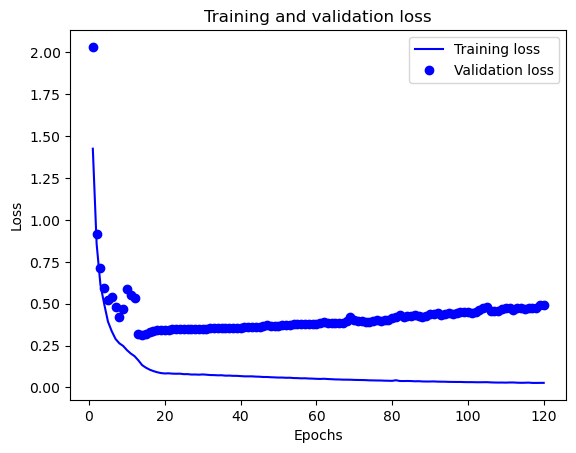

In [25]:
history_dict = history.history
history_dict.keys()
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training loss")
plt.plot(epochs, val_loss_values, "bo", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

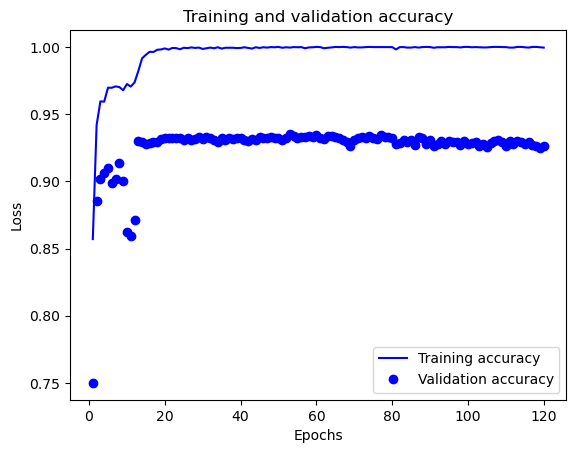

In [26]:
history_dict = history.history
history_dict.keys()
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["accuracy"]
val_loss_values = history_dict["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training accuracy")
plt.plot(epochs, val_loss_values, "bo", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step
(1044,)
(1044, 1)
[1 0 1 ... 1 0 1]
***** confusion matric*****


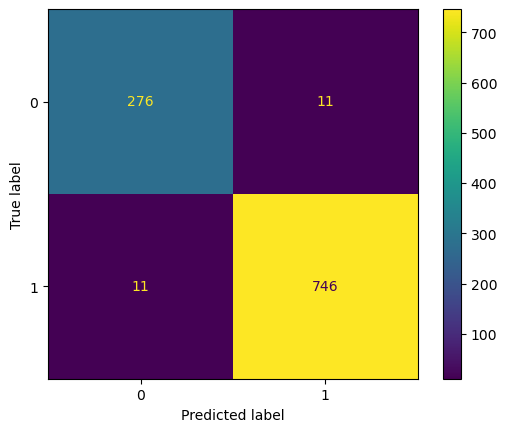

***** precision*****


0.9735707151372326

In [27]:
from sklearn.metrics import classification_report, confusion_matrix,precision_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# testing
predictions=model.predict(test_images)
y_pred= np.argmax(predictions, axis=1)
print(y_pred.shape)
print(test_labels.shape)
print(y_pred)

print("***** confusion matric*****")
cm = confusion_matrix(y_pred, test_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
#precision global
print("***** precision*****")
precision_score(y_pred, test_labels,average='macro')